#!Импорт файлов и загрузка данных

In [ ]:
import os
import random
import shutil
import zipfile
from collections import Counter

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import cv2

from torchvision import transforms, datasets
import timm

import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm

from google.colab import files



# Запрос файла у пользователя
arch = files.upload()  # откроет окно выбора файла


Saving dl-2025-competition-1.zip to dl-2025-competition-1.zip


# !Распаковка файлов

In [ ]:
# Распаковываем архив с данными в папку "unzipped"
with zipfile.ZipFile("dl-2025-competition-1.zip") as archive:
    archive.extractall("unzipped")

Корневая директория после распаковки: ['sample_submission.csv', 'data']
Что внутри основной папки с данными: ['train', 'test']
Содержимое папки train: ['81', '83', '58', '57', '55', '44', '6', '45', '22', '37', '24', '77', '71', '5', '88', '68', '95', '78', '67', '10', '31', '94', '59', '42', '7', '35', '56', '99', '76', '84', '17', '28', '74', '73', '46', '3', '92', '18', '0', '34', '38', '96', '69', '75', '21', '8', '98', '36', '62', '20', '82', '39', '72', '41', '60', '80', '12', '19', '30', '26', '54', '40', '90', '65', '64', '32', '70', '9', '25', '16', '79', '97', '14', '33', '51', '52', '49', '47', '48', '11', '43', '91', '2', '50', '13', '86', '85', '4', '53', '87', '89', '29', '27', '61', '1', '66', '93', '63', '23', '15']
Содержимое папки test: ['3410.png', '2647.png', '2468.png', '2470.png', '733.png', '3832.png', '2225.png', '3247.png', '3391.png', '492.png', '3757.png', '1966.png', '2123.png', '3538.png', '226.png', '1198.png', '3817.png', '1652.png', '651.png', '3046.png'

# !Осматриваем данные и строим распределение

🔍 Обнаружено 100 уникальных классов.
🏆 Класс с наибольшим числом примеров: ('85', 150)
⚠️ Класс с наименьшим числом примеров: ('23', 32)


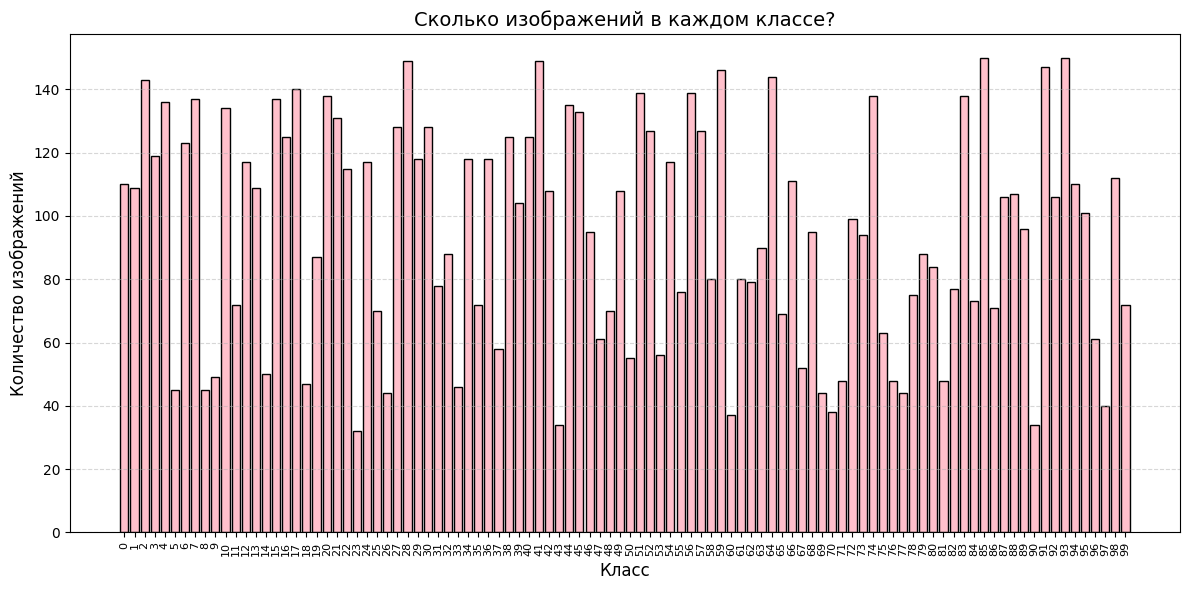

<ipython-input-4-035c13f6d08e>:68: UserWarning: Glyph 128247 (\N{CAMERA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


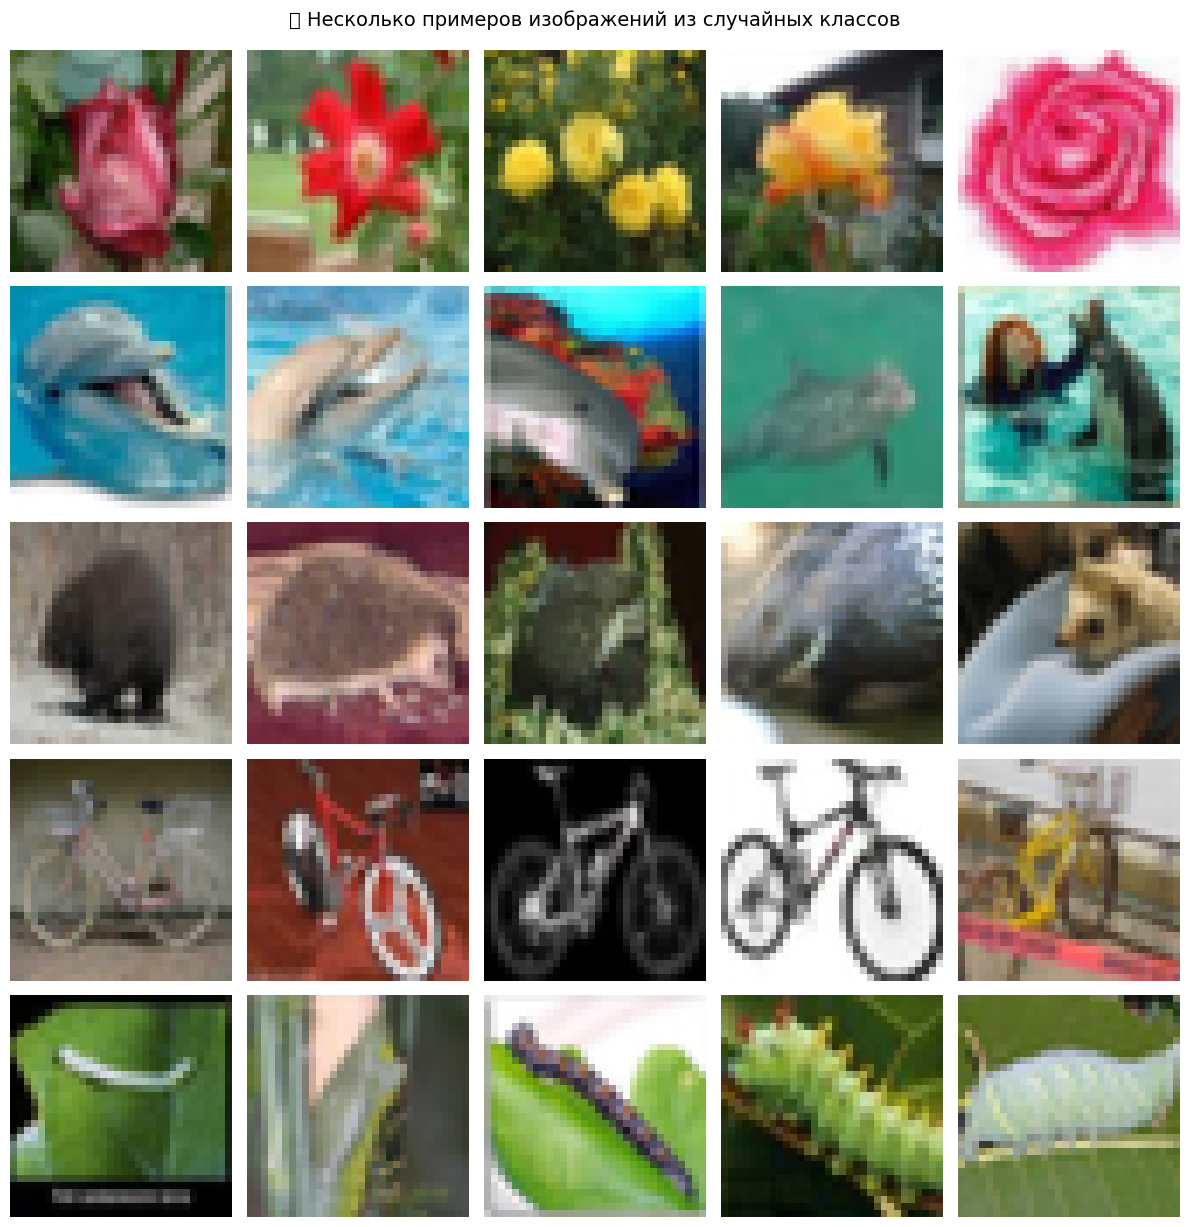

In [ ]:
# Путь к папке с обучающими изображениями
root = 'unzipped/data/train'

# Получаем список всех категорий
labels = sorted(os.listdir(root))
print(f'🔍 Обнаружено {len(labels)} уникальных классов.')

# Подсчитываем, сколько изображений в каждой категории
counts = {lbl: len(os.listdir(os.path.join(root, lbl))) for lbl in labels}

# Сортируем классы по количеству картинок
ranked = sorted(counts.items(), key=lambda x: x[1], reverse=True)
print(f'🏆 Класс с наибольшим числом примеров: {ranked[0]}')
print(f'⚠️ Класс с наименьшим числом примеров: {ranked[-1]}')

# Для визуализации удобно отсортировать по номеру класса (если это числа)
ordered = dict(sorted(counts.items(), key=lambda x: int(x[0])))

# 📊 Визуализация распределения — теперь не просто столбцы, а "лепестковая" гистограмма
plt.figure(figsize=(12, 6))
bars = plt.bar(ordered.keys(), ordered.values(), color='pink', edgecolor='black')
plt.xticks(rotation=90, fontsize=8)
plt.title("Сколько изображений в каждом классе?", fontsize=14)
plt.xlabel("Класс", fontsize=12)
plt.ylabel("Количество изображений", fontsize=12)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# 🖼️ Покажем примеры: выберем случайные классы и отобразим по несколько картинок из каждого
classes_shown = 5
imgs_each = 5
picked = random.sample(labels, classes_shown)

# Простой resize трансформ — просто чтобы привести картинки к одному размеру
img_resize = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

fig, axes = plt.subplots(classes_shown, imgs_each, figsize=(12, 2.5 * classes_shown))

# Пройдемся по выбранным классам и покажем несколько случайных изображений из каждого
for row, cat in enumerate(picked):
    pics = random.sample(os.listdir(os.path.join(root, cat)), imgs_each)
    for col, fname in enumerate(pics):
        fpath = os.path.join(root, cat, fname)
        img = Image.open(fpath).convert('RGB')
        axes[row, col].imshow(img)
        axes[row, col].axis('off')

        # Добавим рамку и подпиcь слева
        axes[row, col].spines[:].set_visible(True)
        for spine in axes[row, col].spines.values():
            spine.set_edgecolor('lightgray')
            spine.set_linewidth(0.8)

        if col == 0:
            axes[row, col].set_ylabel(f'Класс {cat}', fontsize=10, rotation=0, labelpad=40, va='center')

plt.suptitle("📷 Несколько примеров изображений из случайных классов", fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()



# !Строим аугментации

In [ ]:
# аугментации 2
# Параметры
IMG_SIZE = 128  # размер, подаваемый на вход модели

# Аугментации для train
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=15, p=0.3),
    A.HueSaturationValue(p=0.2),
    A.RandomCrop(height=IMG_SIZE, width=IMG_SIZE, p=0.1),
    A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.2),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.2),
    A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=0.2),
    A.MotionBlur(p=0.2),
    A.ElasticTransform(p=0.1),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.2),
    A.Normalize(),
    ToTensorV2()
])

# Аугментации для валидации / теста (только приведение к виду)
val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(),
    ToTensorV2()
])

# Кастомный Dataset
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        for class_id in os.listdir(root_dir):
            class_path = os.path.join(root_dir, class_id)
            if os.path.isdir(class_path):
                for fname in os.listdir(class_path):
                    fpath = os.path.join(class_path, fname)
                    self.samples.append((fpath, int(class_id)))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)['image']
        return image, label


<ipython-input-6-3761f6fccf9e>:14: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.2),
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


# Демонстрация работы аугментаций

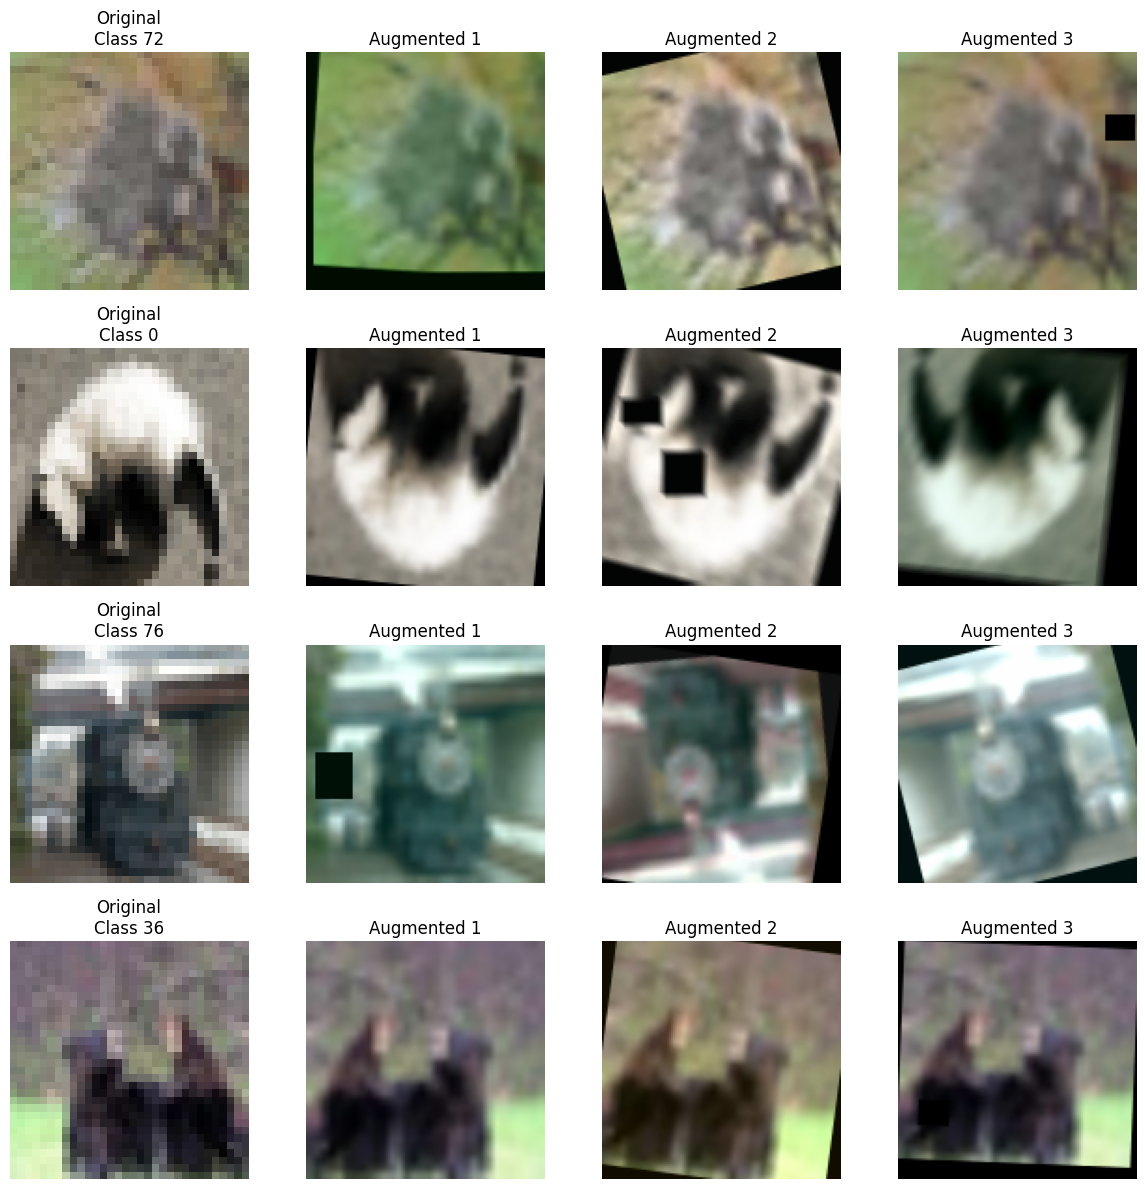

In [ ]:
def show_augmented_grid(dataset_dir, transform, num_classes=4, augmentations_per_class=3):
    import matplotlib.pyplot as plt

    classes = random.sample(os.listdir(dataset_dir), num_classes)
    fig, axs = plt.subplots(num_classes, augmentations_per_class + 1, figsize=(3 * (augmentations_per_class + 1), 3 * num_classes))

    for i, class_id in enumerate(classes):
        class_path = os.path.join(dataset_dir, class_id)
        image_name = random.choice(os.listdir(class_path))
        image_path = os.path.join(class_path, image_name)

        image_orig = cv2.imread(image_path)
        image_orig = cv2.cvtColor(image_orig, cv2.COLOR_BGR2RGB)

        # Слева — оригинал
        axs[i, 0].imshow(image_orig)
        axs[i, 0].set_title(f"Original\nClass {class_id}")
        axs[i, 0].axis("off")

        for j in range(1, augmentations_per_class + 1):
            aug = transform(image=image_orig)["image"]
            img = aug.permute(1, 2, 0).numpy()
            img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
            img = (img * 255).clip(0, 255).astype("uint8")

            axs[i, j].imshow(img)
            axs[i, j].set_title(f"Augmented {j}")
            axs[i, j].axis("off")

    plt.tight_layout()
    plt.show()

# Вызов
show_augmented_grid('unzipped/data/train', train_transform, num_classes=4, augmentations_per_class=3)



# !Делим на трейн и вал

In [ ]:


def split_train_val(original_data_dir, new_base_dir, val_size=0.2):
    classes = os.listdir(original_data_dir)
    os.makedirs(f"{new_base_dir}/train", exist_ok=True)
    os.makedirs(f"{new_base_dir}/val", exist_ok=True)

    for cls in tqdm(classes):
        cls_path = os.path.join(original_data_dir, cls)
        images = os.listdir(cls_path)
        train_imgs, val_imgs = train_test_split(images, test_size=val_size, random_state=42)

        os.makedirs(os.path.join(new_base_dir, "train", cls), exist_ok=True)
        os.makedirs(os.path.join(new_base_dir, "val", cls), exist_ok=True)

        for img in train_imgs:
            shutil.copy(os.path.join(cls_path, img), os.path.join(new_base_dir, "train", cls, img))
        for img in val_imgs:
            shutil.copy(os.path.join(cls_path, img), os.path.join(new_base_dir, "val", cls, img))

# Вызов
split_train_val('unzipped/data/train', "data_split", val_size=0.2)

100%|██████████| 100/100 [00:00<00:00, 134.06it/s]


# !Модель на каггл. Предобученная с продвинутым апскейлингом и крутой аугментацией

In [1]:
#модель на выгрузку на каггл. предобученная с продвинутым апскейлингом и крутой аугментацией

# Устройство
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

# Настройки
IMG_DIM = 128
BATCH_SIZE = 32
EPOCHS = 40
PATIENCE = 4
LEARNING_RATE = 1e-4
NUM_CLASSES = 100

# Аугментации
train_aug = A.Compose([
    A.Resize(IMG_DIM, IMG_DIM, interpolation=cv2.INTER_LANCZOS4),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=15, p=0.3),
    A.HueSaturationValue(p=0.2),
    A.RandomCrop(height=IMG_DIM, width=IMG_DIM, p=0.1),
    A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.2),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.2),
    A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=0.2),
    A.MotionBlur(p=0.2),
    A.ElasticTransform(p=0.1),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.2),
    A.Normalize(),
    ToTensorV2()
])

val_aug = A.Compose([
    A.Resize(IMG_DIM, IMG_DIM, interpolation=cv2.INTER_LANCZOS4),
    A.Normalize(),
    ToTensorV2()
])

# Кастомный датасет
class ImageDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)["image"]
        return image, label

    def __len__(self):
        return len(self.samples)

# Загрузка путей и меток
def load_dataset(root_dir):
    samples = []
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(sorted(os.listdir(root_dir)))}
    for cls_name, idx in class_to_idx.items():
        class_dir = os.path.join(root_dir, cls_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            samples.append((img_path, idx))
    return samples, list(class_to_idx.keys())

# Взвешивание классов
def compute_class_weights(samples, n_classes):
    label_hist = Counter([lbl for _, lbl in samples])
    total = sum(label_hist.values())
    weights = [total / (label_hist[i] * n_classes) for i in range(n_classes)]
    return torch.tensor(weights, dtype=torch.float)

# Обучение
def train_epoch(model, loader, optimizer, loss_fn):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for imgs, lbls in loader:
        imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = loss_fn(outputs, lbls)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(1)
        correct += (preds == lbls).sum().item()
        total += lbls.size(0)
    return total_loss / total, 100 * correct / total

# Валидация с TTA
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
            outputs_list = []
            for flip in [lambda x: x, lambda x: torch.flip(x, dims=[3]), lambda x: torch.flip(x, dims=[2])]:
                outputs_list.append(model(flip(imgs)))
            outputs = torch.stack(outputs_list).mean(0)
            preds = outputs.argmax(1)
            correct += (preds == lbls).sum().item()
            total += lbls.size(0)
    return 100 * correct / total

# Загрузка данных
train_samples, label_names = load_dataset("data_split/train")
val_samples, _ = load_dataset("data_split/val")

train_ds = ImageDataset(train_samples, transform=train_aug)
val_ds = ImageDataset(val_samples, transform=val_aug)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)

# Модель и обучение
weights = compute_class_weights(train_samples, len(label_names)).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)

model = timm.create_model("resnet50", pretrained=True, num_classes=len(label_names)).to(DEVICE)
for param in model.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

best_acc = 0
patience_counter = 0
history = {"train_acc": [], "val_acc": [], "train_loss": []}

# Цикл обучения
for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_dl, optimizer, criterion)
    val_acc = evaluate(model, val_dl)
    scheduler.step(val_acc)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(f"[{epoch+1}/{EPOCHS}] Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_resnet50_model.pth")
        print("✅ Модель сохранена")
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"⏳ Без улучшений {patience_counter} эпох")

    if patience_counter >= PATIENCE:
        print("⛔ Ранняя остановка")
        break

# Визуализация
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history["train_loss"], label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
<ipython-input-1-68e80df24f49>:36: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.2),
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


FileNotFoundError: [Errno 2] No such file or directory: 'data_split/train'

# предобученная без продвинутого апскейлинга и с крутой аугментацией

In [ ]:
# предобученная без продвинутого апскейлинга и с крутой аугментацией


# Устройство
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

# Настройки
IMG_DIM = 128
BATCH_SIZE = 32
EPOCHS = 40
PATIENCE = 4
LEARNING_RATE = 1e-4
NUM_CLASSES = 100

# Аугментации
train_aug = A.Compose([
    A.Resize(IMG_DIM, IMG_DIM),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=15, p=0.3),
    A.HueSaturationValue(p=0.2),
    A.RandomCrop(height=IMG_DIM, width=IMG_DIM, p=0.1),
    A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.2),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.2),
    A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=0.2),
    A.MotionBlur(p=0.2),
    A.ElasticTransform(p=0.1),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.2),
    A.Normalize(),
    ToTensorV2()
])

val_aug = A.Compose([
    A.Resize(IMG_DIM, IMG_DIM),
    A.Normalize(),
    ToTensorV2()
])

# Кастомный датасет
class ImageDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)["image"]
        return image, label

    def __len__(self):
        return len(self.samples)

# Загрузка путей и меток
def load_dataset(root_dir):
    samples = []
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(sorted(os.listdir(root_dir)))}
    for cls_name, idx in class_to_idx.items():
        class_dir = os.path.join(root_dir, cls_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            samples.append((img_path, idx))
    return samples, list(class_to_idx.keys())

# Взвешивание классов
def compute_class_weights(samples, n_classes):
    label_hist = Counter([lbl for _, lbl in samples])
    total = sum(label_hist.values())
    weights = [total / (label_hist[i] * n_classes) for i in range(n_classes)]
    return torch.tensor(weights, dtype=torch.float)

# Обучение
def train_epoch(model, loader, optimizer, loss_fn):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for imgs, lbls in loader:
        imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = loss_fn(outputs, lbls)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(1)
        correct += (preds == lbls).sum().item()
        total += lbls.size(0)
    return total_loss / total, 100 * correct / total

# Валидация с TTA
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
            outputs_list = []
            for flip in [lambda x: x, lambda x: torch.flip(x, dims=[3]), lambda x: torch.flip(x, dims=[2])]:
                outputs_list.append(model(flip(imgs)))
            outputs = torch.stack(outputs_list).mean(0)
            preds = outputs.argmax(1)
            correct += (preds == lbls).sum().item()
            total += lbls.size(0)
    return 100 * correct / total

# Загрузка данных
train_samples, label_names = load_dataset("data_split/train")
val_samples, _ = load_dataset("data_split/val")

train_ds = ImageDataset(train_samples, transform=train_aug)
val_ds = ImageDataset(val_samples, transform=val_aug)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)

# Модель и обучение
weights = compute_class_weights(train_samples, len(label_names)).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)

model = timm.create_model("resnet50", pretrained=True, num_classes=len(label_names)).to(DEVICE)
for param in model.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

best_acc = 0
patience_counter = 0
history = {"train_acc": [], "val_acc": [], "train_loss": []}

# Цикл обучения
for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_dl, optimizer, criterion)
    val_acc = evaluate(model, val_dl)
    scheduler.step(val_acc)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(f"[{epoch+1}/{EPOCHS}] Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_resnet50_model_no_up.pth")
        print("✅ Модель сохранена")
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"⏳ Без улучшений {patience_counter} эпох")

    if patience_counter >= PATIENCE:
        print("⛔ Ранняя остановка")
        break

# Визуализация
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history["train_loss"], label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# предобученная без продвинутого апскейлинга и без крутой аугментации

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/30


100%|██████████| 31/31 [00:02<00:00, 10.77it/s]


Train Loss: 3.4763 | Train Acc: 0.3292
Val   Loss: 2.0533 | Val   Acc: 0.5913
✅ Model saved!

Epoch 2/30


100%|██████████| 31/31 [00:03<00:00, 10.05it/s]


Train Loss: 1.6466 | Train Acc: 0.7388
Val   Loss: 1.5938 | Val   Acc: 0.7482
✅ Model saved!

Epoch 3/30


100%|██████████| 31/31 [00:02<00:00, 10.96it/s]


Train Loss: 1.1762 | Train Acc: 0.8926
Val   Loss: 1.4942 | Val   Acc: 0.7668
✅ Model saved!

Epoch 4/30


100%|██████████| 31/31 [00:03<00:00,  8.76it/s]


Train Loss: 1.0065 | Train Acc: 0.9513
Val   Loss: 1.4560 | Val   Acc: 0.7859
✅ Model saved!

Epoch 5/30


100%|██████████| 31/31 [00:03<00:00,  8.86it/s]


Train Loss: 0.9183 | Train Acc: 0.9752
Val   Loss: 1.4611 | Val   Acc: 0.7802

Epoch 6/30


100%|██████████| 31/31 [00:02<00:00, 11.11it/s]


Train Loss: 0.8712 | Train Acc: 0.9880
Val   Loss: 1.4439 | Val   Acc: 0.7884
✅ Model saved!

Epoch 7/30


100%|██████████| 31/31 [00:02<00:00, 11.11it/s]


Train Loss: 0.8426 | Train Acc: 0.9946
Val   Loss: 1.4469 | Val   Acc: 0.7921
✅ Model saved!

Epoch 8/30


100%|██████████| 31/31 [00:03<00:00,  8.02it/s]


Train Loss: 0.8314 | Train Acc: 0.9966
Val   Loss: 1.4609 | Val   Acc: 0.7921

Epoch 9/30


100%|██████████| 31/31 [00:02<00:00, 11.19it/s]


Train Loss: 0.8196 | Train Acc: 0.9983
Val   Loss: 1.4806 | Val   Acc: 0.7859

Epoch 10/30


100%|██████████| 31/31 [00:02<00:00, 11.00it/s]


Train Loss: 0.8159 | Train Acc: 0.9989
Val   Loss: 1.4700 | Val   Acc: 0.7890

Epoch 11/30


100%|██████████| 31/31 [00:03<00:00,  8.79it/s]


Train Loss: 0.8078 | Train Acc: 0.9992
Val   Loss: 1.4739 | Val   Acc: 0.7890

Epoch 12/30


100%|██████████| 31/31 [00:02<00:00, 11.07it/s]


Train Loss: 0.8030 | Train Acc: 0.9996
Val   Loss: 1.4718 | Val   Acc: 0.7931
✅ Model saved!

Epoch 13/30


100%|██████████| 31/31 [00:02<00:00, 10.99it/s]


Train Loss: 0.7998 | Train Acc: 0.9995
Val   Loss: 1.4771 | Val   Acc: 0.7895

Epoch 14/30


100%|██████████| 31/31 [00:03<00:00,  9.28it/s]


Train Loss: 0.7984 | Train Acc: 0.9997
Val   Loss: 1.4763 | Val   Acc: 0.7890

Epoch 15/30


100%|██████████| 31/31 [00:02<00:00, 10.79it/s]


Train Loss: 0.7961 | Train Acc: 0.9999
Val   Loss: 1.4731 | Val   Acc: 0.7967
✅ Model saved!

Epoch 16/30


100%|██████████| 31/31 [00:02<00:00, 10.72it/s]


Train Loss: 0.7947 | Train Acc: 0.9999
Val   Loss: 1.4697 | Val   Acc: 0.7988
✅ Model saved!

Epoch 17/30


100%|██████████| 31/31 [00:02<00:00, 10.69it/s]


Train Loss: 0.7943 | Train Acc: 0.9999
Val   Loss: 1.4785 | Val   Acc: 0.7957

Epoch 18/30


100%|██████████| 31/31 [00:02<00:00, 10.99it/s]


Train Loss: 0.7927 | Train Acc: 0.9999
Val   Loss: 1.4745 | Val   Acc: 0.7962

Epoch 19/30


100%|██████████| 31/31 [00:03<00:00, 10.17it/s]


Train Loss: 0.7921 | Train Acc: 1.0000
Val   Loss: 1.4723 | Val   Acc: 0.8008
✅ Model saved!

Epoch 20/30


100%|██████████| 31/31 [00:02<00:00, 11.01it/s]


Train Loss: 0.7915 | Train Acc: 0.9996
Val   Loss: 1.4725 | Val   Acc: 0.8050
✅ Model saved!

Epoch 21/30


100%|██████████| 31/31 [00:02<00:00, 10.77it/s]


Train Loss: 0.7905 | Train Acc: 1.0000
Val   Loss: 1.4727 | Val   Acc: 0.7936

Epoch 22/30


100%|██████████| 31/31 [00:03<00:00,  8.46it/s]


Train Loss: 0.7911 | Train Acc: 0.9996
Val   Loss: 1.4929 | Val   Acc: 0.7946

Epoch 23/30


100%|██████████| 31/31 [00:03<00:00, 10.17it/s]


Train Loss: 0.7893 | Train Acc: 1.0000
Val   Loss: 1.4819 | Val   Acc: 0.7941

Epoch 24/30


100%|██████████| 31/31 [00:02<00:00, 10.63it/s]


Train Loss: 0.7883 | Train Acc: 1.0000
Val   Loss: 1.4837 | Val   Acc: 0.8044

Epoch 25/30


100%|██████████| 31/31 [00:03<00:00,  8.76it/s]


Train Loss: 0.7879 | Train Acc: 1.0000
Val   Loss: 1.4821 | Val   Acc: 0.7998
🛑 Early stopping triggered.

Best validation accuracy: 0.8050


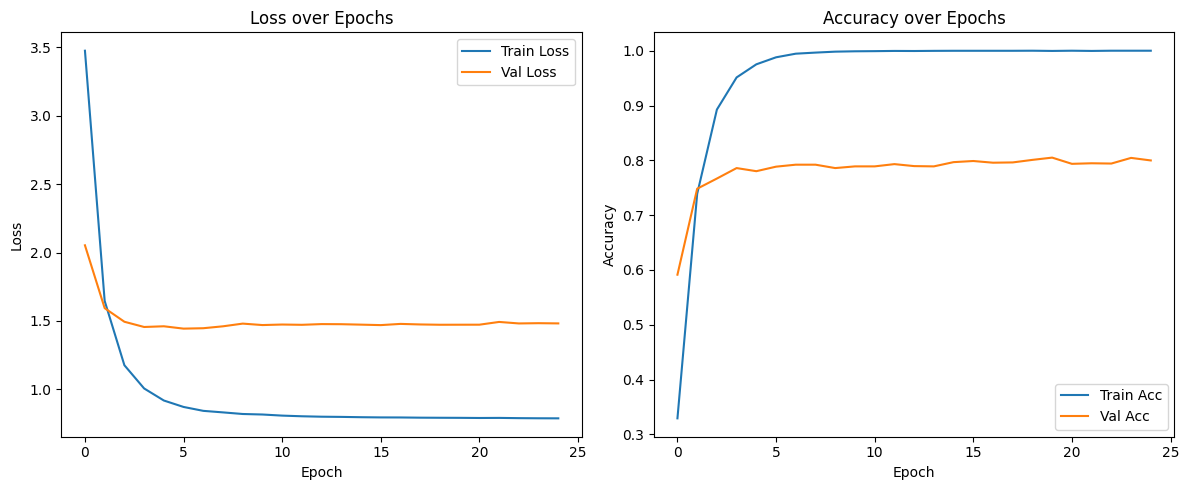

In [ ]:
# предобученная без продвинутого апскейлинга и без крутой аугментации


# Устройство
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

# Настройки
IMG_DIM = 128
BATCH_SIZE = 32
EPOCHS = 40
PATIENCE = 4
LEARNING_RATE = 1e-4
NUM_CLASSES = 100

# === Простые аугментации ===
train_aug = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.Normalize(),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(),
    ToTensorV2()
])

val_aug = A.Compose([
    A.Resize(IMG_DIM, IMG_DIM),
    A.Normalize(),
    ToTensorV2()
])

# Кастомный датасет
class ImageDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)["image"]
        return image, label

    def __len__(self):
        return len(self.samples)

# Загрузка путей и меток
def load_dataset(root_dir):
    samples = []
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(sorted(os.listdir(root_dir)))}
    for cls_name, idx in class_to_idx.items():
        class_dir = os.path.join(root_dir, cls_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            samples.append((img_path, idx))
    return samples, list(class_to_idx.keys())

# Взвешивание классов
def compute_class_weights(samples, n_classes):
    label_hist = Counter([lbl for _, lbl in samples])
    total = sum(label_hist.values())
    weights = [total / (label_hist[i] * n_classes) for i in range(n_classes)]
    return torch.tensor(weights, dtype=torch.float)

# Обучение
def train_epoch(model, loader, optimizer, loss_fn):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for imgs, lbls in loader:
        imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = loss_fn(outputs, lbls)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(1)
        correct += (preds == lbls).sum().item()
        total += lbls.size(0)
    return total_loss / total, 100 * correct / total

# Валидация с TTA
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
            outputs_list = []
            for flip in [lambda x: x, lambda x: torch.flip(x, dims=[3]), lambda x: torch.flip(x, dims=[2])]:
                outputs_list.append(model(flip(imgs)))
            outputs = torch.stack(outputs_list).mean(0)
            preds = outputs.argmax(1)
            correct += (preds == lbls).sum().item()
            total += lbls.size(0)
    return 100 * correct / total

# Загрузка данных
train_samples, label_names = load_dataset("data_split/train")
val_samples, _ = load_dataset("data_split/val")

train_ds = ImageDataset(train_samples, transform=train_aug)
val_ds = ImageDataset(val_samples, transform=val_aug)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)

# Модель и обучение
weights = compute_class_weights(train_samples, len(label_names)).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)

model = timm.create_model("resnet50", pretrained=True, num_classes=len(label_names)).to(DEVICE)
for param in model.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

best_acc = 0
patience_counter = 0
history = {"train_acc": [], "val_acc": [], "train_loss": []}

# Цикл обучения
for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_dl, optimizer, criterion)
    val_acc = evaluate(model, val_dl)
    scheduler.step(val_acc)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(f"[{epoch+1}/{EPOCHS}] Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_resnet50_no_aug.pth")
        print("✅ Модель сохранена")
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"⏳ Без улучшений {patience_counter} эпох")

    if patience_counter >= PATIENCE:
        print("⛔ Ранняя остановка")
        break

# Визуализация
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history["train_loss"], label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Не предоубченная без ничего

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/30


100%|██████████| 31/31 [00:03<00:00,  9.89it/s]


Train Loss: 4.4546 | Train Acc: 0.0498
Val   Loss: 4.2686 | Val   Acc: 0.0820
✅ Model saved!

Epoch 2/30


100%|██████████| 31/31 [00:03<00:00,  9.38it/s]


Train Loss: 4.2476 | Train Acc: 0.0790
Val   Loss: 4.0832 | Val   Acc: 0.1135
✅ Model saved!

Epoch 3/30


100%|██████████| 31/31 [00:03<00:00,  9.11it/s]


Train Loss: 4.1171 | Train Acc: 0.1037
Val   Loss: 3.9705 | Val   Acc: 0.1238
✅ Model saved!

Epoch 4/30


100%|██████████| 31/31 [00:03<00:00,  9.76it/s]


Train Loss: 4.0104 | Train Acc: 0.1165
Val   Loss: 3.8672 | Val   Acc: 0.1486
✅ Model saved!

Epoch 5/30


100%|██████████| 31/31 [00:03<00:00,  9.97it/s]


Train Loss: 3.9291 | Train Acc: 0.1206
Val   Loss: 3.8050 | Val   Acc: 0.1445

Epoch 6/30


100%|██████████| 31/31 [00:03<00:00,  9.62it/s]


Train Loss: 3.8573 | Train Acc: 0.1337
Val   Loss: 3.7553 | Val   Acc: 0.1574
✅ Model saved!

Epoch 7/30


100%|██████████| 31/31 [00:03<00:00,  9.56it/s]


Train Loss: 3.7908 | Train Acc: 0.1458
Val   Loss: 3.6642 | Val   Acc: 0.1801
✅ Model saved!

Epoch 8/30


100%|██████████| 31/31 [00:03<00:00, 10.11it/s]


Train Loss: 3.7255 | Train Acc: 0.1630
Val   Loss: 3.6274 | Val   Acc: 0.1785

Epoch 9/30


100%|██████████| 31/31 [00:03<00:00, 10.15it/s]


Train Loss: 3.6667 | Train Acc: 0.1745
Val   Loss: 3.5702 | Val   Acc: 0.2064
✅ Model saved!

Epoch 10/30


100%|██████████| 31/31 [00:03<00:00,  8.87it/s]


Train Loss: 3.5997 | Train Acc: 0.1829
Val   Loss: 3.5287 | Val   Acc: 0.2105
✅ Model saved!

Epoch 11/30


100%|██████████| 31/31 [00:03<00:00,  9.89it/s]


Train Loss: 3.5416 | Train Acc: 0.2039
Val   Loss: 3.5005 | Val   Acc: 0.2147
✅ Model saved!

Epoch 12/30


100%|██████████| 31/31 [00:03<00:00, 10.16it/s]


Train Loss: 3.4824 | Train Acc: 0.2110
Val   Loss: 3.4605 | Val   Acc: 0.2147

Epoch 13/30


100%|██████████| 31/31 [00:03<00:00, 10.13it/s]


Train Loss: 3.4278 | Train Acc: 0.2258
Val   Loss: 3.4268 | Val   Acc: 0.2322
✅ Model saved!

Epoch 14/30


100%|██████████| 31/31 [00:03<00:00,  8.55it/s]


Train Loss: 3.3757 | Train Acc: 0.2349
Val   Loss: 3.3063 | Val   Acc: 0.2528
✅ Model saved!

Epoch 15/30


100%|██████████| 31/31 [00:03<00:00,  9.93it/s]


Train Loss: 3.3286 | Train Acc: 0.2484
Val   Loss: 3.3445 | Val   Acc: 0.2534
✅ Model saved!

Epoch 16/30


100%|██████████| 31/31 [00:03<00:00, 10.06it/s]


Train Loss: 3.2799 | Train Acc: 0.2633
Val   Loss: 3.2636 | Val   Acc: 0.2668
✅ Model saved!

Epoch 17/30


100%|██████████| 31/31 [00:03<00:00, 10.14it/s]


Train Loss: 3.2289 | Train Acc: 0.2760
Val   Loss: 3.2204 | Val   Acc: 0.2771
✅ Model saved!

Epoch 18/30


100%|██████████| 31/31 [00:03<00:00,  8.63it/s]


Train Loss: 3.1705 | Train Acc: 0.2896
Val   Loss: 3.2789 | Val   Acc: 0.2719

Epoch 19/30


100%|██████████| 31/31 [00:03<00:00, 10.18it/s]


Train Loss: 3.1536 | Train Acc: 0.2924
Val   Loss: 3.2716 | Val   Acc: 0.2786
✅ Model saved!

Epoch 20/30


100%|██████████| 31/31 [00:03<00:00, 10.08it/s]


Train Loss: 3.1007 | Train Acc: 0.3090
Val   Loss: 3.1834 | Val   Acc: 0.2905
✅ Model saved!

Epoch 21/30


100%|██████████| 31/31 [00:03<00:00, 10.08it/s]


Train Loss: 3.0713 | Train Acc: 0.3181
Val   Loss: 3.3221 | Val   Acc: 0.2709

Epoch 22/30


100%|██████████| 31/31 [00:03<00:00,  8.27it/s]


Train Loss: 3.0172 | Train Acc: 0.3283
Val   Loss: 3.1405 | Val   Acc: 0.3240
✅ Model saved!

Epoch 23/30


100%|██████████| 31/31 [00:03<00:00,  9.46it/s]


Train Loss: 2.9697 | Train Acc: 0.3457
Val   Loss: 3.0983 | Val   Acc: 0.3173

Epoch 24/30


100%|██████████| 31/31 [00:03<00:00, 10.08it/s]


Train Loss: 2.9337 | Train Acc: 0.3578
Val   Loss: 3.0646 | Val   Acc: 0.3246
✅ Model saved!

Epoch 25/30


100%|██████████| 31/31 [00:03<00:00,  9.83it/s]


Train Loss: 2.9071 | Train Acc: 0.3596
Val   Loss: 3.1086 | Val   Acc: 0.3220

Epoch 26/30


100%|██████████| 31/31 [00:04<00:00,  6.45it/s]


Train Loss: 2.8698 | Train Acc: 0.3737
Val   Loss: 3.0314 | Val   Acc: 0.3271
✅ Model saved!

Epoch 27/30


100%|██████████| 31/31 [00:03<00:00,  9.52it/s]


Train Loss: 2.8277 | Train Acc: 0.3805
Val   Loss: 3.0827 | Val   Acc: 0.3256

Epoch 28/30


100%|██████████| 31/31 [00:03<00:00,  9.99it/s]


Train Loss: 2.8005 | Train Acc: 0.3904
Val   Loss: 3.0247 | Val   Acc: 0.3406
✅ Model saved!

Epoch 29/30


100%|██████████| 31/31 [00:03<00:00, 10.01it/s]


Train Loss: 2.7618 | Train Acc: 0.4035
Val   Loss: 2.9581 | Val   Acc: 0.3540
✅ Model saved!

Epoch 30/30


100%|██████████| 31/31 [00:03<00:00,  8.84it/s]


Train Loss: 2.7090 | Train Acc: 0.4153
Val   Loss: 2.9048 | Val   Acc: 0.3617
✅ Model saved!

Best validation accuracy: 0.3617


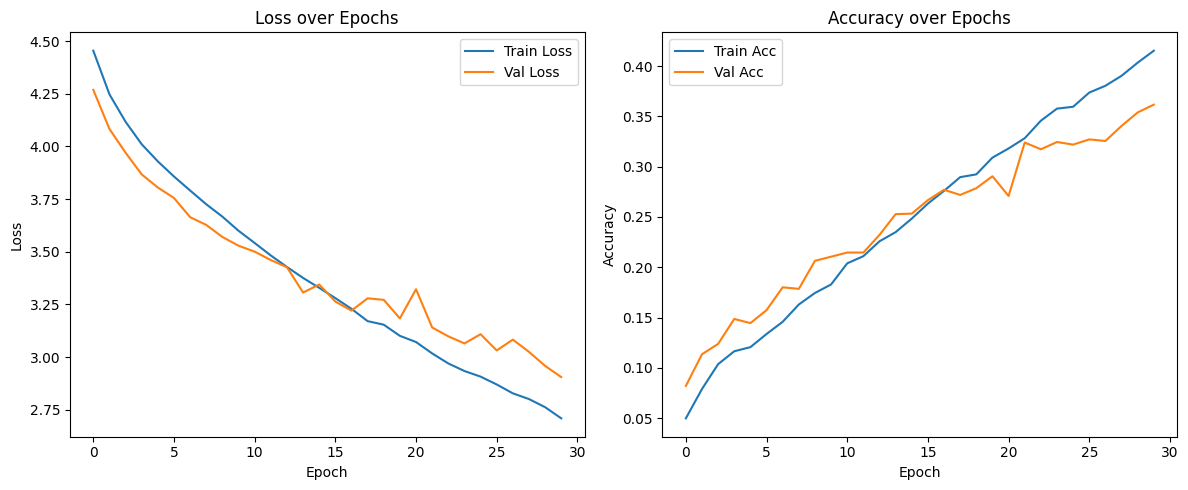

In [ ]:
#Не предоубченная без ничего. Как-то не очень вышло

# === Константы ===
BATCH_SIZE = 64
EPOCHS = 30
NUM_CLASSES = 100
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 128
PATIENCE = 5  # Для early stopping

# === Аугментации ===
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.Normalize(),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(),
    ToTensorV2()
])

# === Dataset Wrapper ===
class AlbumentationsDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform):
        self.dataset = datasets.ImageFolder(root=root_dir)
        self.transform = transform

    def __getitem__(self, index):
        image, label = self.dataset[index]
        image = np.array(image)
        image = self.transform(image=image)['image']
        return image, label

    def __len__(self):
        return len(self.dataset)

# === Data Loaders ===
train_dataset = AlbumentationsDataset("data_split/train", train_transform)
val_dataset = AlbumentationsDataset("data_split/val", val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

class DeeperCNN(nn.Module):
    def __init__(self, num_classes):
        super(DeeperCNN, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 128 -> 64

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64 -> 32

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32 -> 16

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 16 -> 8

            nn.AdaptiveAvgPool2d((1, 1))  # output: Bx512x1x1
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


model = DeeperCNN(NUM_CLASSES).to(DEVICE)

# === Loss, Optimizer, Scheduler ===
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

# === Training and Validation ===
def train(model, loader):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for x, y in tqdm(loader):
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        correct += (preds.argmax(1) == y).sum().item()
        total += x.size(0)
    return total_loss / total, correct / total

def validate(model, loader):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for x, y in tqdm(loader):
            x, y = x.to(DEVICE), y.to(DEVICE)
            preds = model(x)
            loss = criterion(preds, y)
            total_loss += loss.item() * x.size(0)
            correct += (preds.argmax(1) == y).sum().item()
            total += x.size(0)
    return total_loss / total, correct / total

# === Main Training Loop ===
best_acc = 0
epochs_no_improve = 4
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    train_loss, train_acc = train(model, train_loader)
    val_loss, val_acc = validate(model, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

    scheduler.step(val_acc)

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Model saved!")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("🛑 Early stopping triggered.")
            break

print(f"\nBest validation accuracy: {best_acc:.4f}")

# === Plotting ===
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Acc")
plt.plot(val_accuracies, label="Val Acc")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.savefig("training_curves.png")
plt.show()


# Непредобученная со сложными аугмнетациями

<ipython-input-16-54bd4dbc0407>:33: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.2),
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is depre


Epoch 1/50


100%|██████████| 31/31 [00:03<00:00, 10.15it/s]


Train Loss: 4.4799 | Train Acc: 0.0394
Val   Loss: 4.2970 | Val   Acc: 0.0686
✅ Model saved!

Epoch 2/50


100%|██████████| 31/31 [00:03<00:00, 10.20it/s]


Train Loss: 4.3302 | Train Acc: 0.0647
Val   Loss: 4.1626 | Val   Acc: 0.0893
✅ Model saved!

Epoch 3/50


100%|██████████| 31/31 [00:03<00:00,  9.85it/s]


Train Loss: 4.2526 | Train Acc: 0.0700
Val   Loss: 4.0639 | Val   Acc: 0.1037
✅ Model saved!

Epoch 4/50


100%|██████████| 31/31 [00:03<00:00, 10.14it/s]


Train Loss: 4.1853 | Train Acc: 0.0741
Val   Loss: 4.0129 | Val   Acc: 0.1104
✅ Model saved!

Epoch 5/50


100%|██████████| 31/31 [00:03<00:00, 10.26it/s]


Train Loss: 4.1380 | Train Acc: 0.0854
Val   Loss: 3.9761 | Val   Acc: 0.1244
✅ Model saved!

Epoch 6/50


100%|██████████| 31/31 [00:03<00:00,  9.45it/s]


Train Loss: 4.0806 | Train Acc: 0.0940
Val   Loss: 3.9002 | Val   Acc: 0.1440
✅ Model saved!

Epoch 7/50


100%|██████████| 31/31 [00:03<00:00, 10.10it/s]


Train Loss: 4.0473 | Train Acc: 0.0988
Val   Loss: 3.8768 | Val   Acc: 0.1398

Epoch 8/50


100%|██████████| 31/31 [00:03<00:00, 10.20it/s]


Train Loss: 4.0067 | Train Acc: 0.1030
Val   Loss: 3.7997 | Val   Acc: 0.1558
✅ Model saved!

Epoch 9/50


100%|██████████| 31/31 [00:03<00:00,  9.38it/s]


Train Loss: 3.9618 | Train Acc: 0.1182
Val   Loss: 3.7568 | Val   Acc: 0.1610
✅ Model saved!

Epoch 10/50


100%|██████████| 31/31 [00:03<00:00,  9.92it/s]


Train Loss: 3.9274 | Train Acc: 0.1193
Val   Loss: 3.7133 | Val   Acc: 0.1662
✅ Model saved!

Epoch 11/50


100%|██████████| 31/31 [00:03<00:00, 10.22it/s]


Train Loss: 3.8873 | Train Acc: 0.1294
Val   Loss: 3.6875 | Val   Acc: 0.1672
✅ Model saved!

Epoch 12/50


100%|██████████| 31/31 [00:03<00:00,  9.11it/s]


Train Loss: 3.8534 | Train Acc: 0.1314
Val   Loss: 3.6223 | Val   Acc: 0.1847
✅ Model saved!

Epoch 13/50


100%|██████████| 31/31 [00:03<00:00, 10.25it/s]


Train Loss: 3.8139 | Train Acc: 0.1420
Val   Loss: 3.6079 | Val   Acc: 0.1889
✅ Model saved!

Epoch 14/50


100%|██████████| 31/31 [00:03<00:00,  9.78it/s]


Train Loss: 3.7701 | Train Acc: 0.1566
Val   Loss: 3.5474 | Val   Acc: 0.1930
✅ Model saved!

Epoch 15/50


100%|██████████| 31/31 [00:03<00:00,  8.36it/s]


Train Loss: 3.7368 | Train Acc: 0.1550
Val   Loss: 3.5552 | Val   Acc: 0.1935
✅ Model saved!

Epoch 16/50


100%|██████████| 31/31 [00:03<00:00, 10.00it/s]


Train Loss: 3.7063 | Train Acc: 0.1611
Val   Loss: 3.4910 | Val   Acc: 0.2100
✅ Model saved!

Epoch 17/50


100%|██████████| 31/31 [00:03<00:00, 10.01it/s]


Train Loss: 3.6724 | Train Acc: 0.1701
Val   Loss: 3.4731 | Val   Acc: 0.2147
✅ Model saved!

Epoch 18/50


100%|██████████| 31/31 [00:03<00:00,  8.84it/s]


Train Loss: 3.6273 | Train Acc: 0.1775
Val   Loss: 3.4318 | Val   Acc: 0.2270
✅ Model saved!

Epoch 19/50


100%|██████████| 31/31 [00:03<00:00, 10.12it/s]


Train Loss: 3.5894 | Train Acc: 0.1840
Val   Loss: 3.4264 | Val   Acc: 0.2384
✅ Model saved!

Epoch 20/50


100%|██████████| 31/31 [00:03<00:00, 10.13it/s]


Train Loss: 3.5396 | Train Acc: 0.1956
Val   Loss: 3.3153 | Val   Acc: 0.2528
✅ Model saved!

Epoch 21/50


100%|██████████| 31/31 [00:03<00:00,  8.87it/s]


Train Loss: 3.5242 | Train Acc: 0.2002
Val   Loss: 3.3332 | Val   Acc: 0.2528

Epoch 22/50


100%|██████████| 31/31 [00:03<00:00,  9.91it/s]


Train Loss: 3.4889 | Train Acc: 0.2155
Val   Loss: 3.3212 | Val   Acc: 0.2456

Epoch 23/50


100%|██████████| 31/31 [00:03<00:00, 10.14it/s]


Train Loss: 3.4664 | Train Acc: 0.2235
Val   Loss: 3.3689 | Val   Acc: 0.2389

Epoch 24/50


100%|██████████| 31/31 [00:03<00:00, 10.18it/s]


Train Loss: 3.3822 | Train Acc: 0.2371
Val   Loss: 3.1618 | Val   Acc: 0.2998
✅ Model saved!

Epoch 25/50


100%|██████████| 31/31 [00:03<00:00,  9.23it/s]


Train Loss: 3.3462 | Train Acc: 0.2472
Val   Loss: 3.1411 | Val   Acc: 0.3080
✅ Model saved!

Epoch 26/50


100%|██████████| 31/31 [00:03<00:00, 10.19it/s]


Train Loss: 3.3275 | Train Acc: 0.2521
Val   Loss: 3.1416 | Val   Acc: 0.2982

Epoch 27/50


100%|██████████| 31/31 [00:03<00:00, 10.03it/s]


Train Loss: 3.3084 | Train Acc: 0.2555
Val   Loss: 3.0983 | Val   Acc: 0.3086
✅ Model saved!

Epoch 28/50


100%|██████████| 31/31 [00:03<00:00,  8.40it/s]


Train Loss: 3.2932 | Train Acc: 0.2571
Val   Loss: 3.1181 | Val   Acc: 0.3091
✅ Model saved!

Epoch 29/50


100%|██████████| 31/31 [00:03<00:00, 10.09it/s]


Train Loss: 3.2619 | Train Acc: 0.2670
Val   Loss: 3.0890 | Val   Acc: 0.3225
✅ Model saved!

Epoch 30/50


100%|██████████| 31/31 [00:03<00:00, 10.11it/s]


Train Loss: 3.2448 | Train Acc: 0.2748
Val   Loss: 3.0614 | Val   Acc: 0.3246
✅ Model saved!

Epoch 31/50


100%|██████████| 31/31 [00:03<00:00,  8.65it/s]


Train Loss: 3.2344 | Train Acc: 0.2680
Val   Loss: 3.0800 | Val   Acc: 0.3117

Epoch 32/50


100%|██████████| 31/31 [00:03<00:00, 10.00it/s]


Train Loss: 3.2140 | Train Acc: 0.2834
Val   Loss: 3.0402 | Val   Acc: 0.3163

Epoch 33/50


100%|██████████| 31/31 [00:03<00:00,  9.85it/s]


Train Loss: 3.2055 | Train Acc: 0.2806
Val   Loss: 3.0376 | Val   Acc: 0.3215

Epoch 34/50


100%|██████████| 31/31 [00:03<00:00, 10.13it/s]


Train Loss: 3.1590 | Train Acc: 0.2957
Val   Loss: 2.9849 | Val   Acc: 0.3354
✅ Model saved!

Epoch 35/50


100%|██████████| 31/31 [00:03<00:00,  9.32it/s]


Train Loss: 3.1428 | Train Acc: 0.3001
Val   Loss: 2.9810 | Val   Acc: 0.3400
✅ Model saved!

Epoch 36/50


100%|██████████| 31/31 [00:03<00:00, 10.12it/s]


Train Loss: 3.1079 | Train Acc: 0.3106
Val   Loss: 2.9445 | Val   Acc: 0.3447
✅ Model saved!

Epoch 37/50


100%|██████████| 31/31 [00:03<00:00, 10.13it/s]


Train Loss: 3.1142 | Train Acc: 0.3044
Val   Loss: 2.9505 | Val   Acc: 0.3540
✅ Model saved!

Epoch 38/50


100%|██████████| 31/31 [00:03<00:00,  9.02it/s]


Train Loss: 3.1019 | Train Acc: 0.3090
Val   Loss: 2.9648 | Val   Acc: 0.3437

Epoch 39/50


100%|██████████| 31/31 [00:03<00:00, 10.12it/s]


Train Loss: 3.0938 | Train Acc: 0.3130
Val   Loss: 2.9373 | Val   Acc: 0.3607
✅ Model saved!

Epoch 40/50


100%|██████████| 31/31 [00:03<00:00,  9.98it/s]


Train Loss: 3.0888 | Train Acc: 0.3105
Val   Loss: 2.9511 | Val   Acc: 0.3442

Epoch 41/50


100%|██████████| 31/31 [00:03<00:00,  8.48it/s]


Train Loss: 3.0833 | Train Acc: 0.3094
Val   Loss: 2.9191 | Val   Acc: 0.3633
✅ Model saved!

Epoch 42/50


100%|██████████| 31/31 [00:03<00:00, 10.20it/s]


Train Loss: 3.0644 | Train Acc: 0.3247
Val   Loss: 2.9127 | Val   Acc: 0.3566

Epoch 43/50


100%|██████████| 31/31 [00:03<00:00, 10.08it/s]


Train Loss: 3.0467 | Train Acc: 0.3240
Val   Loss: 2.9463 | Val   Acc: 0.3576

Epoch 44/50


100%|██████████| 31/31 [00:03<00:00,  8.77it/s]


Train Loss: 3.0344 | Train Acc: 0.3290
Val   Loss: 2.9319 | Val   Acc: 0.3581

Epoch 45/50


100%|██████████| 31/31 [00:03<00:00, 10.23it/s]


Train Loss: 3.0070 | Train Acc: 0.3333
Val   Loss: 2.8658 | Val   Acc: 0.3762
✅ Model saved!

Epoch 46/50


100%|██████████| 31/31 [00:03<00:00, 10.00it/s]


Train Loss: 2.9948 | Train Acc: 0.3402
Val   Loss: 2.8699 | Val   Acc: 0.3674

Epoch 47/50


100%|██████████| 31/31 [00:03<00:00,  8.74it/s]


Train Loss: 2.9951 | Train Acc: 0.3335
Val   Loss: 2.8602 | Val   Acc: 0.3854
✅ Model saved!

Epoch 48/50


100%|██████████| 31/31 [00:03<00:00, 10.04it/s]


Train Loss: 3.0079 | Train Acc: 0.3352
Val   Loss: 2.8546 | Val   Acc: 0.3762

Epoch 49/50


100%|██████████| 31/31 [00:03<00:00, 10.18it/s]


Train Loss: 2.9956 | Train Acc: 0.3386
Val   Loss: 2.8555 | Val   Acc: 0.3803

Epoch 50/50


100%|██████████| 31/31 [00:03<00:00,  8.76it/s]


Train Loss: 2.9920 | Train Acc: 0.3364
Val   Loss: 2.8549 | Val   Acc: 0.3772

Best validation accuracy: 0.3854


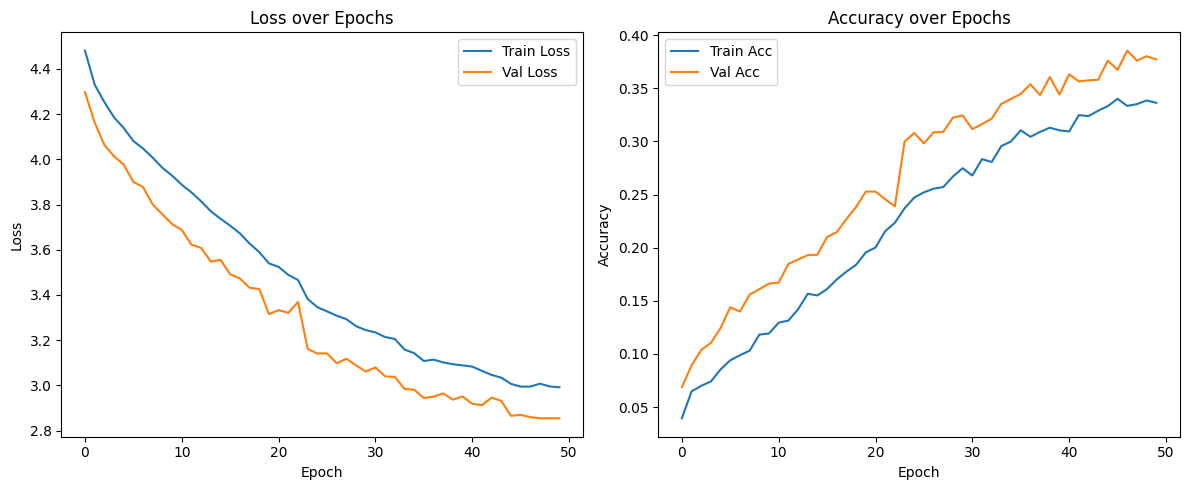

In [ ]:
#Непредобученная со сложными аугмнетациями

# === Константы ===
BATCH_SIZE = 64
EPOCHS = 50
NUM_CLASSES = 100
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 128
PATIENCE = 5  # Для early stopping

# === Аугментации ===
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=15, p=0.3),
    A.HueSaturationValue(p=0.2),
    A.RandomCrop(height=IMG_SIZE, width=IMG_SIZE, p=0.1),
    A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.2),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.2),
    A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=0.2),
    A.MotionBlur(p=0.2),
    A.ElasticTransform(p=0.1),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.2),
    A.Normalize(),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(),
    ToTensorV2()
])

# === Dataset Wrapper ===
class AlbumentationsDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform):
        self.dataset = datasets.ImageFolder(root=root_dir)
        self.transform = transform

    def __getitem__(self, index):
        image, label = self.dataset[index]
        image = np.array(image)
        image = self.transform(image=image)['image']
        return image, label

    def __len__(self):
        return len(self.dataset)

# === Data Loaders ===
train_dataset = AlbumentationsDataset("data_split/train", train_transform)
val_dataset = AlbumentationsDataset("data_split/val", val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

class DeeperCNN(nn.Module):
    def __init__(self, num_classes):
        super(DeeperCNN, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 128 -> 64

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64 -> 32

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32 -> 16

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 16 -> 8

            nn.AdaptiveAvgPool2d((1, 1))  # output: Bx512x1x1
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


model = DeeperCNN(NUM_CLASSES).to(DEVICE)

# === Loss, Optimizer, Scheduler ===
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

# === Training and Validation ===
def train(model, loader):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for x, y in tqdm(loader):
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        correct += (preds.argmax(1) == y).sum().item()
        total += x.size(0)
    return total_loss / total, correct / total

def validate(model, loader):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for x, y in tqdm(loader):
            x, y = x.to(DEVICE), y.to(DEVICE)
            preds = model(x)
            loss = criterion(preds, y)
            total_loss += loss.item() * x.size(0)
            correct += (preds.argmax(1) == y).sum().item()
            total += x.size(0)
    return total_loss / total, correct / total

# === Main Training Loop ===
best_acc = 0
epochs_no_improve = 4
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    train_loss, train_acc = train(model, train_loader)
    val_loss, val_acc = validate(model, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

    scheduler.step(val_acc)

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print("✅ Model saved!")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("🛑 Early stopping triggered.")
            break

print(f"\nBest validation accuracy: {best_acc:.4f}")

# === Plotting ===
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Acc")
plt.plot(val_accuracies, label="Val Acc")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.savefig("training_curves.png")
plt.show()


#Непредобученная со сложными аугмнетациями и апскейлингом

In [ ]:
#Непредобученная со сложными аугмнетациями и апскейлингом

# === Константы ===
BATCH_SIZE = 64
EPOCHS = 50
NUM_CLASSES = 100
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 128
PATIENCE = 5  # Для early stopping

# === Аугментации ===
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE, interpolation=cv2.INTER_LANCZOS4),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=15, p=0.3),
    A.HueSaturationValue(p=0.2),
    A.RandomCrop(height=IMG_SIZE, width=IMG_SIZE, p=0.1),
    A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.2),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.2),
    A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=0.2),
    A.MotionBlur(p=0.2),
    A.ElasticTransform(p=0.1),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.2),
    A.Normalize(),
    ToTensorV2()
])

val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE, interpolation=cv2.INTER_LANCZOS4),
    A.Normalize(),
    ToTensorV2()
])

# === Dataset Wrapper ===
class AlbumentationsDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform):
        self.dataset = datasets.ImageFolder(root=root_dir)
        self.transform = transform

    def __getitem__(self, index):
        image, label = self.dataset[index]
        image = np.array(image)
        image = self.transform(image=image)['image']
        return image, label

    def __len__(self):
        return len(self.dataset)

# === Data Loaders ===
train_dataset = AlbumentationsDataset("data_split/train", train_transform)
val_dataset = AlbumentationsDataset("data_split/val", val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

class DeeperCNN(nn.Module):
    def __init__(self, num_classes):
        super(DeeperCNN, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 128 -> 64

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 64 -> 32

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 32 -> 16

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 16 -> 8

            nn.AdaptiveAvgPool2d((1, 1))  # output: Bx512x1x1
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


model = DeeperCNN(NUM_CLASSES).to(DEVICE)

# === Loss, Optimizer, Scheduler ===
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

# === Training and Validation ===
def train(model, loader):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for x, y in tqdm(loader):
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        preds = model(x)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        correct += (preds.argmax(1) == y).sum().item()
        total += x.size(0)
    return total_loss / total, correct / total

def validate(model, loader):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for x, y in tqdm(loader):
            x, y = x.to(DEVICE), y.to(DEVICE)
            preds = model(x)
            loss = criterion(preds, y)
            total_loss += loss.item() * x.size(0)
            correct += (preds.argmax(1) == y).sum().item()
            total += x.size(0)
    return total_loss / total, correct / total

# === Main Training Loop ===
best_acc = 0
epochs_no_improve = 4
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    train_loss, train_acc = train(model, train_loader)
    val_loss, val_acc = validate(model, val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")

    scheduler.step(val_acc)

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_model_my.pth")
        print("✅ Model saved!")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("🛑 Early stopping triggered.")
            break

print(f"\nBest validation accuracy: {best_acc:.4f}")

# === Plotting ===
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Acc")
plt.plot(val_accuracies, label="Val Acc")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.savefig("training_curves.png")
plt.show()


<ipython-input-25-580d7276dfea>:33: UserWarning: Argument(s) 'max_holes, max_height, max_width' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.2),
/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is depre


Epoch 1/50


100%|██████████| 31/31 [00:03<00:00,  9.03it/s]


Train Loss: 4.4729 | Train Acc: 0.0464
Val   Loss: 4.3054 | Val   Acc: 0.0815
✅ Model saved!

Epoch 2/50


100%|██████████| 31/31 [00:03<00:00,  9.08it/s]


Train Loss: 4.3187 | Train Acc: 0.0726
Val   Loss: 4.1471 | Val   Acc: 0.1037
✅ Model saved!

Epoch 3/50


100%|██████████| 31/31 [00:04<00:00,  7.63it/s]


Train Loss: 4.2327 | Train Acc: 0.0729
Val   Loss: 4.0653 | Val   Acc: 0.1161
✅ Model saved!

Epoch 4/50


100%|██████████| 31/31 [00:03<00:00,  9.27it/s]


Train Loss: 4.1709 | Train Acc: 0.0901
Val   Loss: 4.0189 | Val   Acc: 0.1233
✅ Model saved!

Epoch 5/50


100%|██████████| 31/31 [00:03<00:00,  9.09it/s]


Train Loss: 4.1253 | Train Acc: 0.0920
Val   Loss: 3.9173 | Val   Acc: 0.1409
✅ Model saved!

Epoch 6/50


100%|██████████| 31/31 [00:04<00:00,  7.29it/s]


Train Loss: 4.0625 | Train Acc: 0.1022
Val   Loss: 3.8852 | Val   Acc: 0.1424
✅ Model saved!

Epoch 7/50


100%|██████████| 31/31 [00:03<00:00,  9.23it/s]


Train Loss: 4.0215 | Train Acc: 0.1051
Val   Loss: 3.8083 | Val   Acc: 0.1445
✅ Model saved!

Epoch 8/50


100%|██████████| 31/31 [00:03<00:00,  9.20it/s]


Train Loss: 3.9743 | Train Acc: 0.1156
Val   Loss: 3.7811 | Val   Acc: 0.1615
✅ Model saved!

Epoch 9/50


100%|██████████| 31/31 [00:04<00:00,  7.70it/s]


Train Loss: 3.9303 | Train Acc: 0.1257
Val   Loss: 3.7072 | Val   Acc: 0.1677
✅ Model saved!

Epoch 10/50


100%|██████████| 31/31 [00:03<00:00,  9.24it/s]


Train Loss: 3.8881 | Train Acc: 0.1268
Val   Loss: 3.6907 | Val   Acc: 0.1713
✅ Model saved!

Epoch 11/50


100%|██████████| 31/31 [00:03<00:00,  8.94it/s]


Train Loss: 3.8357 | Train Acc: 0.1403
Val   Loss: 3.6783 | Val   Acc: 0.1692

Epoch 12/50


100%|██████████| 31/31 [00:03<00:00,  8.00it/s]


Train Loss: 3.8041 | Train Acc: 0.1443
Val   Loss: 3.6192 | Val   Acc: 0.1868
✅ Model saved!

Epoch 13/50


100%|██████████| 31/31 [00:03<00:00,  7.95it/s]


Train Loss: 3.7481 | Train Acc: 0.1598
Val   Loss: 3.5624 | Val   Acc: 0.2033
✅ Model saved!

Epoch 14/50


100%|██████████| 31/31 [00:03<00:00,  9.19it/s]


Train Loss: 3.7017 | Train Acc: 0.1632
Val   Loss: 3.5396 | Val   Acc: 0.2059
✅ Model saved!

Epoch 15/50


  0%|          | 0/119 [00:00<?, ?it/s]


KeyboardInterrupt: 

# Делаем сабмишн на каггл

In [ ]:

# Пути
test_dir = "unzipped/data/test"
sample_path = "unzipped/sample_submission.csv"

# Размер изображений
IMG_SIZE = 128

# Трансформации
val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE, interpolation=cv2.INTER_LANCZOS4),
    A.Normalize(),
    ToTensorV2()
])

# Загрузка модели
model = timm.create_model('resnet50', pretrained=True, num_classes=len(labels))
model.load_state_dict(torch.load("best_resnet50_model.pth", map_location=DEVICE))
model.to(DEVICE)
model.eval()

# Загрузка sample_submission
submission = pd.read_csv(sample_path)

# Сортируем файлы по числовому значению имени файла
image_ids = sorted(os.listdir(test_dir), key=lambda x: int(os.path.splitext(x)[0]))

# Предсказания
preds = []
for img_name in tqdm(image_ids, desc="Predicting"):
    img_path = os.path.join(test_dir, img_name)
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = val_transform(image=image)['image'].unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        output = model(image)
        pred = torch.argmax(output, dim=1).item()
        preds.append(pred)

# Обновляем колонку Target
submission['target'] = preds

# Сохраняем
submission.to_csv("submission.csv", index=False)
print("✅ submission.csv готова к загрузке на Kaggle!")

Predicting: 100%|██████████| 3878/3878 [00:35<00:00, 107.80it/s]

✅ submission.csv готова к загрузке на Kaggle!


## **(!!)Все что ниже - для выбивания скора на каггле (уже было в коде)**

In [ ]:
import os
import random
import shutil
import zipfile
from collections import Counter

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import cv2

from torchvision import transforms, datasets
import timm

import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm

from google.colab import files



# Запрос файла у пользователя
arch = files.upload()  # откроет окно выбора файла


In [ ]:
# Распаковываем архив с данными в папку "unzipped"
with zipfile.ZipFile("dl-2025-competition-1.zip") as archive:
    archive.extractall("unzipped")

# Путь к папке с обучающими изображениями
root = 'unzipped/data/train'

# Получаем список всех категорий
labels = sorted(os.listdir(root))

# Подсчитываем, сколько изображений в каждой категории
counts = {lbl: len(os.listdir(os.path.join(root, lbl))) for lbl in labels}

# Сортируем классы по количеству картинок
ranked = sorted(counts.items(), key=lambda x: x[1], reverse=True)

# Для визуализации удобно отсортировать по номеру класса (если это числа)
ordered = dict(sorted(counts.items(), key=lambda x: int(x[0])))

# аугментации 2
# Параметры
IMG_SIZE = 128  # размер, подаваемый на вход модели

# Аугментации для train
train_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=15, p=0.3),
    A.HueSaturationValue(p=0.2),
    A.RandomCrop(height=IMG_SIZE, width=IMG_SIZE, p=0.1),
    A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.2),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.2),
    A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=0.2),
    A.MotionBlur(p=0.2),
    A.ElasticTransform(p=0.1),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.2),
    A.Normalize(),
    ToTensorV2()
])

# Аугментации для валидации / теста (только приведение к виду)
val_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(),
    ToTensorV2()
])

# Кастомный Dataset
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        for class_id in os.listdir(root_dir):
            class_path = os.path.join(root_dir, class_id)
            if os.path.isdir(class_path):
                for fname in os.listdir(class_path):
                    fpath = os.path.join(class_path, fname)
                    self.samples.append((fpath, int(class_id)))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)['image']
        return image, label



def split_train_val(original_data_dir, new_base_dir, val_size=0.2):
    classes = os.listdir(original_data_dir)
    os.makedirs(f"{new_base_dir}/train", exist_ok=True)
    os.makedirs(f"{new_base_dir}/val", exist_ok=True)

    for cls in tqdm(classes):
        cls_path = os.path.join(original_data_dir, cls)
        images = os.listdir(cls_path)
        train_imgs, val_imgs = train_test_split(images, test_size=val_size, random_state=42)

        os.makedirs(os.path.join(new_base_dir, "train", cls), exist_ok=True)
        os.makedirs(os.path.join(new_base_dir, "val", cls), exist_ok=True)

        for img in train_imgs:
            shutil.copy(os.path.join(cls_path, img), os.path.join(new_base_dir, "train", cls, img))
        for img in val_imgs:
            shutil.copy(os.path.join(cls_path, img), os.path.join(new_base_dir, "val", cls, img))

# Вызов
split_train_val('unzipped/data/train', "data_split", val_size=0.2)

#модель на выгрузку на каггл. предобученная с продвинутым апскейлингом и крутой аугментацией

# Устройство
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

# Настройки
IMG_DIM = 128
BATCH_SIZE = 32
EPOCHS = 40
PATIENCE = 4
LEARNING_RATE = 1e-4
NUM_CLASSES = 100

# Аугментации
train_aug = A.Compose([
    A.Resize(IMG_DIM, IMG_DIM, interpolation=cv2.INTER_LANCZOS4),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.3),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=15, p=0.3),
    A.HueSaturationValue(p=0.2),
    A.RandomCrop(height=IMG_DIM, width=IMG_DIM, p=0.1),
    A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=0.2),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, p=0.2),
    A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=0.2),
    A.MotionBlur(p=0.2),
    A.ElasticTransform(p=0.1),
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.2),
    A.Normalize(),
    ToTensorV2()
])

val_aug = A.Compose([
    A.Resize(IMG_DIM, IMG_DIM, interpolation=cv2.INTER_LANCZOS4),
    A.Normalize(),
    ToTensorV2()
])

# Кастомный датасет
class ImageDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = cv2.imread(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            image = self.transform(image=image)["image"]
        return image, label

    def __len__(self):
        return len(self.samples)

# Загрузка путей и меток
def load_dataset(root_dir):
    samples = []
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(sorted(os.listdir(root_dir)))}
    for cls_name, idx in class_to_idx.items():
        class_dir = os.path.join(root_dir, cls_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            samples.append((img_path, idx))
    return samples, list(class_to_idx.keys())

# Взвешивание классов
def compute_class_weights(samples, n_classes):
    label_hist = Counter([lbl for _, lbl in samples])
    total = sum(label_hist.values())
    weights = [total / (label_hist[i] * n_classes) for i in range(n_classes)]
    return torch.tensor(weights, dtype=torch.float)

# Обучение
def train_epoch(model, loader, optimizer, loss_fn):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for imgs, lbls in loader:
        imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = loss_fn(outputs, lbls)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(1)
        correct += (preds == lbls).sum().item()
        total += lbls.size(0)
    return total_loss / total, 100 * correct / total

# Валидация с TTA
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
            outputs_list = []
            for flip in [lambda x: x, lambda x: torch.flip(x, dims=[3]), lambda x: torch.flip(x, dims=[2])]:
                outputs_list.append(model(flip(imgs)))
            outputs = torch.stack(outputs_list).mean(0)
            preds = outputs.argmax(1)
            correct += (preds == lbls).sum().item()
            total += lbls.size(0)
    return 100 * correct / total

# Загрузка данных
train_samples, label_names = load_dataset("data_split/train")
val_samples, _ = load_dataset("data_split/val")

train_ds = ImageDataset(train_samples, transform=train_aug)
val_ds = ImageDataset(val_samples, transform=val_aug)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE)

# Модель и обучение
weights = compute_class_weights(train_samples, len(label_names)).to(DEVICE)
criterion = nn.CrossEntropyLoss(weight=weights, label_smoothing=0.1)

model = timm.create_model("resnet50", pretrained=True, num_classes=len(label_names)).to(DEVICE)
for param in model.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

best_acc = 0
patience_counter = 0
history = {"train_acc": [], "val_acc": [], "train_loss": []}

# Цикл обучения
for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_dl, optimizer, criterion)
    val_acc = evaluate(model, val_dl)
    scheduler.step(val_acc)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(f"[{epoch+1}/{EPOCHS}] Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_resnet50_model.pth")
        print("✅ Модель сохранена")
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"⏳ Без улучшений {patience_counter} эпох")

    if patience_counter >= PATIENCE:
        print("⛔ Ранняя остановка")
        break

# Визуализация
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history["train_acc"], label="Train Accuracy")
plt.plot(history["val_acc"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy per Epoch")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history["train_loss"], label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss per Epoch")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



 ***Пояснение - возможно что-то не работает, когда-то работало, но в последнюю ночь закончились аккаунты в коллабе для отладки***